# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# Import necessary packages
# Standard library imports
import calendar
import json
import os
import sys

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Machine learning - scikit-learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report

# LightGBM for gradient boosting
import lightgbm as lgb

# Model optimization
import optuna
from optuna.logging import set_verbosity

# Model persistence
import joblib

# Add parent directory to path to import weather module
sys.path.append('../../')

# Import weather module with all utilities
import weather
from weather.plots import set_plot_style

# Set consistent plot styling
set_plot_style()

---
## A. Project Description


In [4]:
# <Student to fill this section>
student_name = "Zhiyuan Zhao"
student_id = "25605217"

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [7]:
# <Student to fill this section>
business_use_case_description = """
Weather prediction model for Sydney that forecasts cumulative precipitation volume over the next three days. Enables 
proactive planning for water resource management, flood prevention, agricultural irrigation scheduling, and infrastructure 
maintenance across various sectors including water utilities, emergency services, and urban planning.
"""

In [8]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [9]:
# <Student to fill this section>
business_objectives = """
Accurate precipitation volume predictions enable optimized water management and flood risk assessment. Underestimation 
leads to inadequate preparation for heavy rainfall events while overestimation triggers unnecessary resource allocation. 
Quantitative forecasts support data-driven decision making for infrastructure planning and emergency response.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [11]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
Water utilities require volume forecasts for reservoir management and supply planning. Emergency services need quantitative 
predictions for flood response resource allocation. Farmers optimize irrigation based on expected precipitation amounts. 
Construction companies schedule concrete pours and outdoor work considering rainfall intensity. Urban planners assess 
stormwater system capacity requirements.
"""

In [12]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [13]:
# Load the raw weather data
data_path = '../../data/raw/sydney_weather_daily.csv'
df = pd.read_csv(data_path)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: from {df['time'].min()} to {df['time'].max()}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset shape: (31046, 21)
Date range: from 1940-01-02 to 2024-12-31

Column names:
['time', 'weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise', 'sunset', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'sunshine_duration', 'daylight_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration']

First 5 rows:


,time,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,rain_sum,snowfall_sum,precipitation_hours,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1940-01-02,51,22.2,17.4,19.6,21.9,16.2,19.2,1940-01-02T04:48,1940-01-02T19:09,...,2.1,0.0,11.0,45748.11,51663.50,17.7,43.9,153,20.18,4.02
1,1940-01-03,51,25.1,16.4,20.8,25.8,17.5,21.5,1940-01-03T04:49,1940-01-03T19:09,...,1.1,0.0,6.0,48408.09,51627.63,19.7,42.1,61,24.04,4.69
2,1940-01-04,3,28.5,16.6,22.6,29.7,17.8,23.4,1940-01-04T04:49,1940-01-04T19:09,...,0.0,0.0,0.0,48245.77,51589.00,18.4,38.9,44,27.77,5.87
3,1940-01-05,55,22.1,19.3,21.0,23.1,20.3,21.9,1940-01-05T04:50,1940-01-05T19:09,...,9.7,0.0,13.0,9645.05,51547.63,17.3,42.8,12,9.98,2.31
4,1940-01-06,53,29.2,19.3,23.5,32.1,19.6,24.7,1940-01-06T04:51,1940-01-06T19:09,...,3.5,0.0,12.0,36146.81,51503.58,16.6,35.6,86,18.12,4.38


### C.2 Define Target variable

In [14]:
# Define target variable
target_name = 'precipitation_3day'

In [15]:
# <Student to fill this section>
target_definition_explanations = """
Continuous target variable representing cumulative precipitation volume in millimeters over the next three days. Three-day 
window balances forecast accuracy with practical planning horizons for water resource management. Regression approach 
provides quantitative predictions essential for infrastructure capacity planning and risk assessment.
"""

In [16]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [17]:
# Create precipitation regression target variable using weather module function
df['precipitation_3day'] = weather.create_precipitation_3day_target(df)
target_name = 'precipitation_3day'

# Check creation results
print(f"Target variable '{target_name}' created successfully")
print(f"Total rows: {len(df)}")
print(f"Rows with valid target: {df[target_name].notna().sum()}")
print(f"Rows with NaN target (last 3 days): {df[target_name].isna().sum()}")

# Remove rows with missing target values (last 3 days)
df_clean = df.dropna(subset=[target_name])

print(f"\nAfter removing last 3 days:")
print(f"Dataset size: {len(df_clean)}")
print(f"Time range: {df_clean['time'].min()} to {df_clean['time'].max()}")

# Basic statistics of target variable
print(f"\nTarget variable statistics:")
print(f"Mean: {df_clean[target_name].mean():.2f} mm")
print(f"Median: {df_clean[target_name].median():.2f} mm")
print(f"Std: {df_clean[target_name].std():.2f} mm")
print(f"Min: {df_clean[target_name].min():.2f} mm")
print(f"Max: {df_clean[target_name].max():.2f} mm")

# Save the cleaned data with target variable to interim folder
interim_path = '../../data/interim/'
os.makedirs(interim_path, exist_ok=True)

# Save only the cleaned data (without last 3 days)
output_file = os.path.join(interim_path, 'sydney_weather_with_precipitation_3day_target.csv')
df_clean.to_csv(output_file, index=False)
print(f"\nCleaned data with target variable saved to: {output_file}")

# Update df to use the cleaned version
df = df_clean.copy()

Target variable 'precipitation_3day' created successfully
Total rows: 31046
Rows with valid target: 31043
Rows with NaN target (last 3 days): 3

After removing last 3 days:
Dataset size: 31043
Time range: 1940-01-02 to 2024-12-28

Target variable statistics:
Mean: 5.92 mm
Median: 1.30 mm
Std: 13.50 mm
Min: 0.00 mm
Max: 296.50 mm

Cleaned data with target variable saved to: ../../data/interim/sydney_weather_with_precipitation_3day_target.csv


### C.4 Explore Target variable

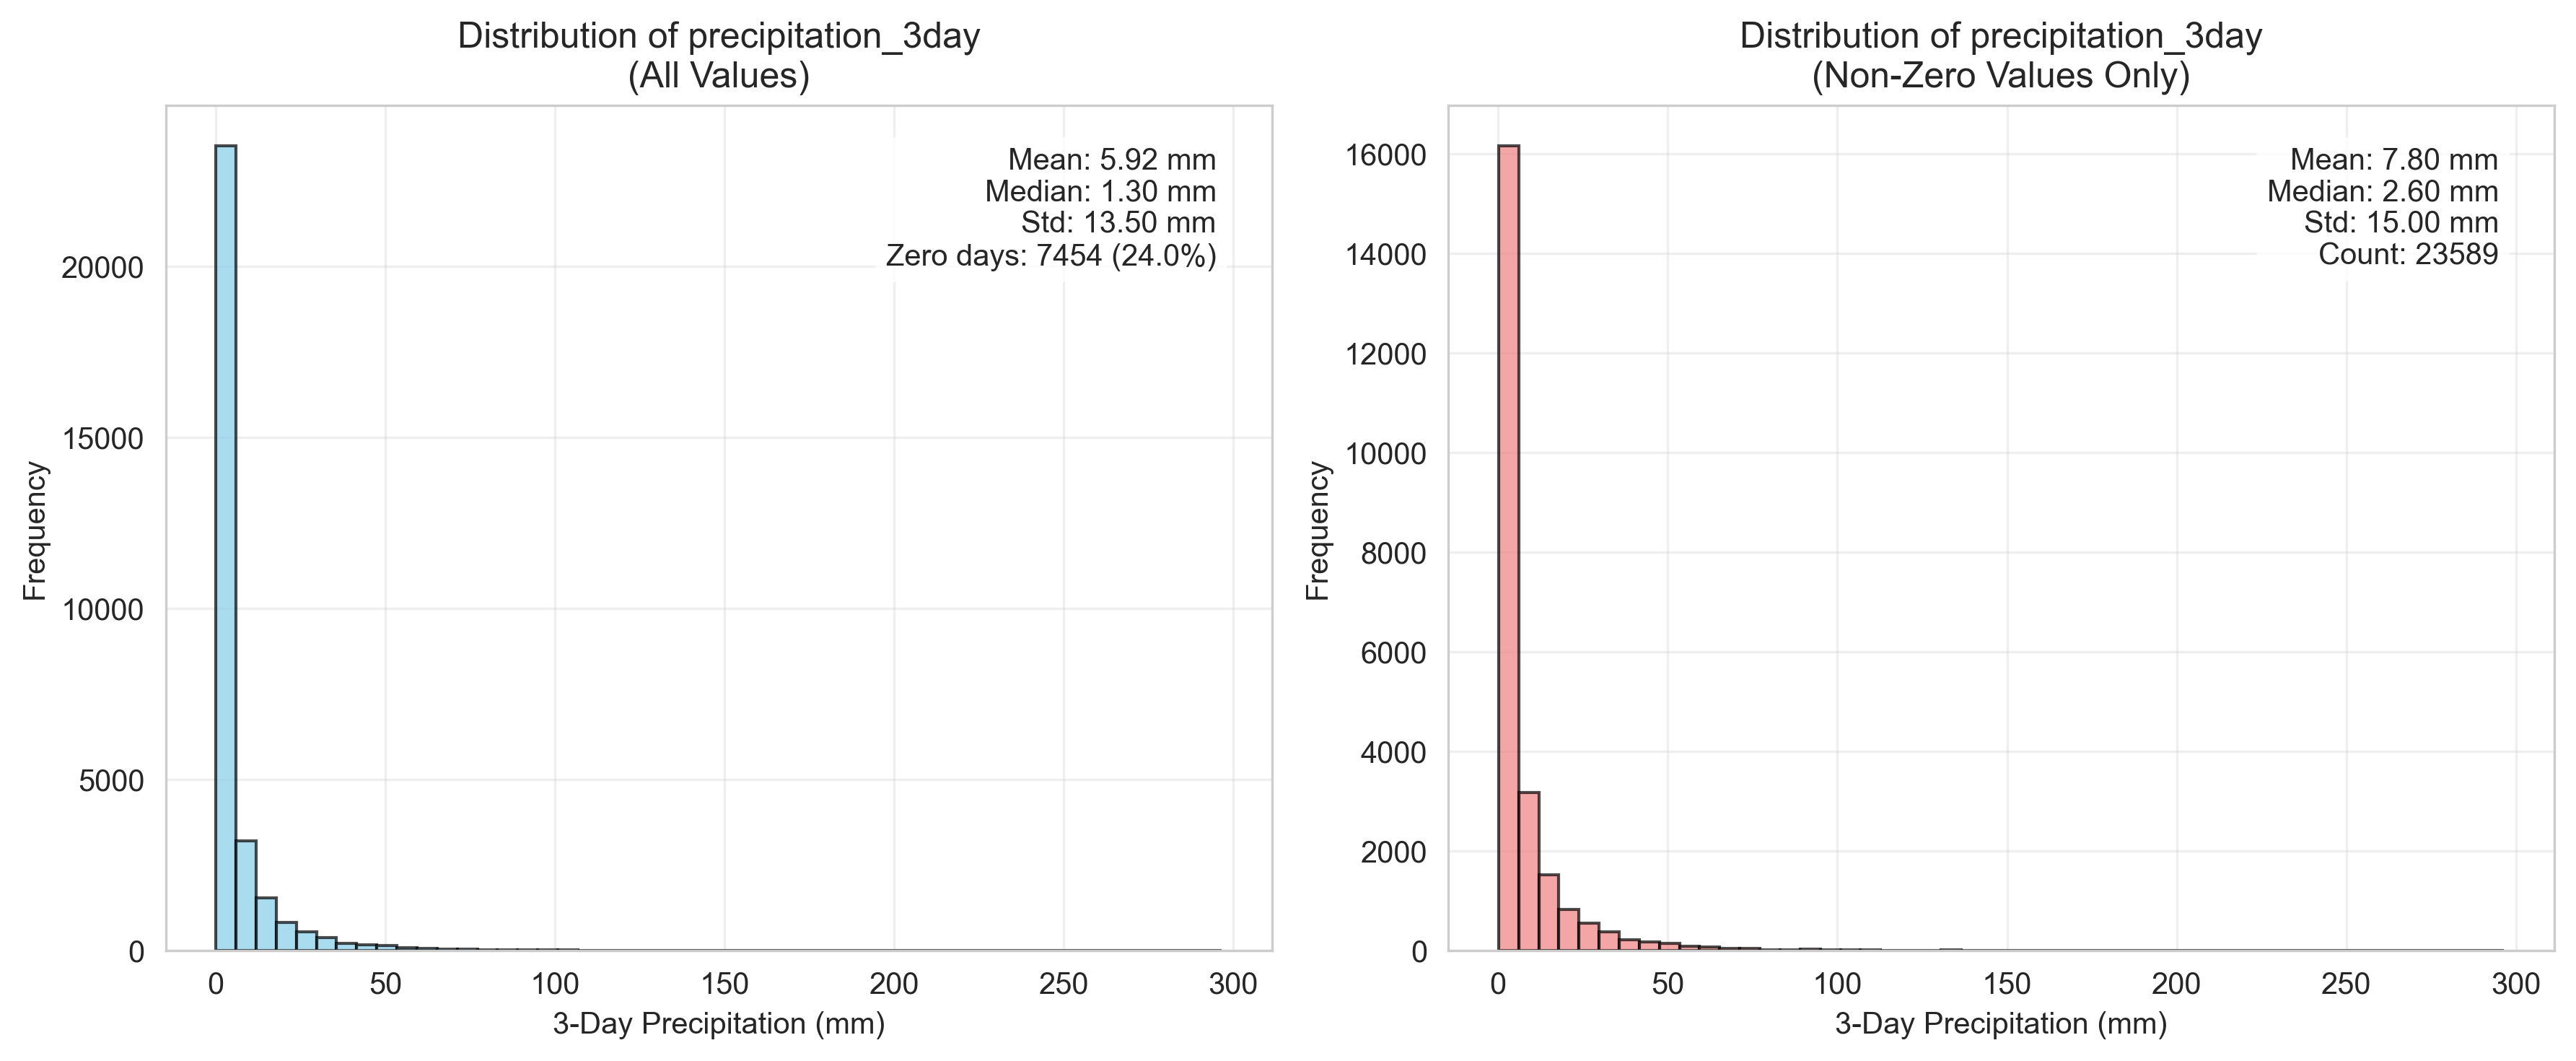

In [18]:
# Explore target variable distribution using weather module
fig = weather.plot_precipitation_distribution(
    df, 
    target_col=target_name,
    figsize=(12, 5)
)

In [19]:
# <Student to fill this section>
target_distribution_explanations = """
Three-day precipitation demonstrates heavily skewed distribution with majority of periods showing minimal 
rainfall. Extreme precipitation events create significant outliers. Zero-inflated nature combined with 
occasional heavy rainfall presents modeling challenges for tree-based approaches.
"""

In [20]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `<precipitation_sum>`

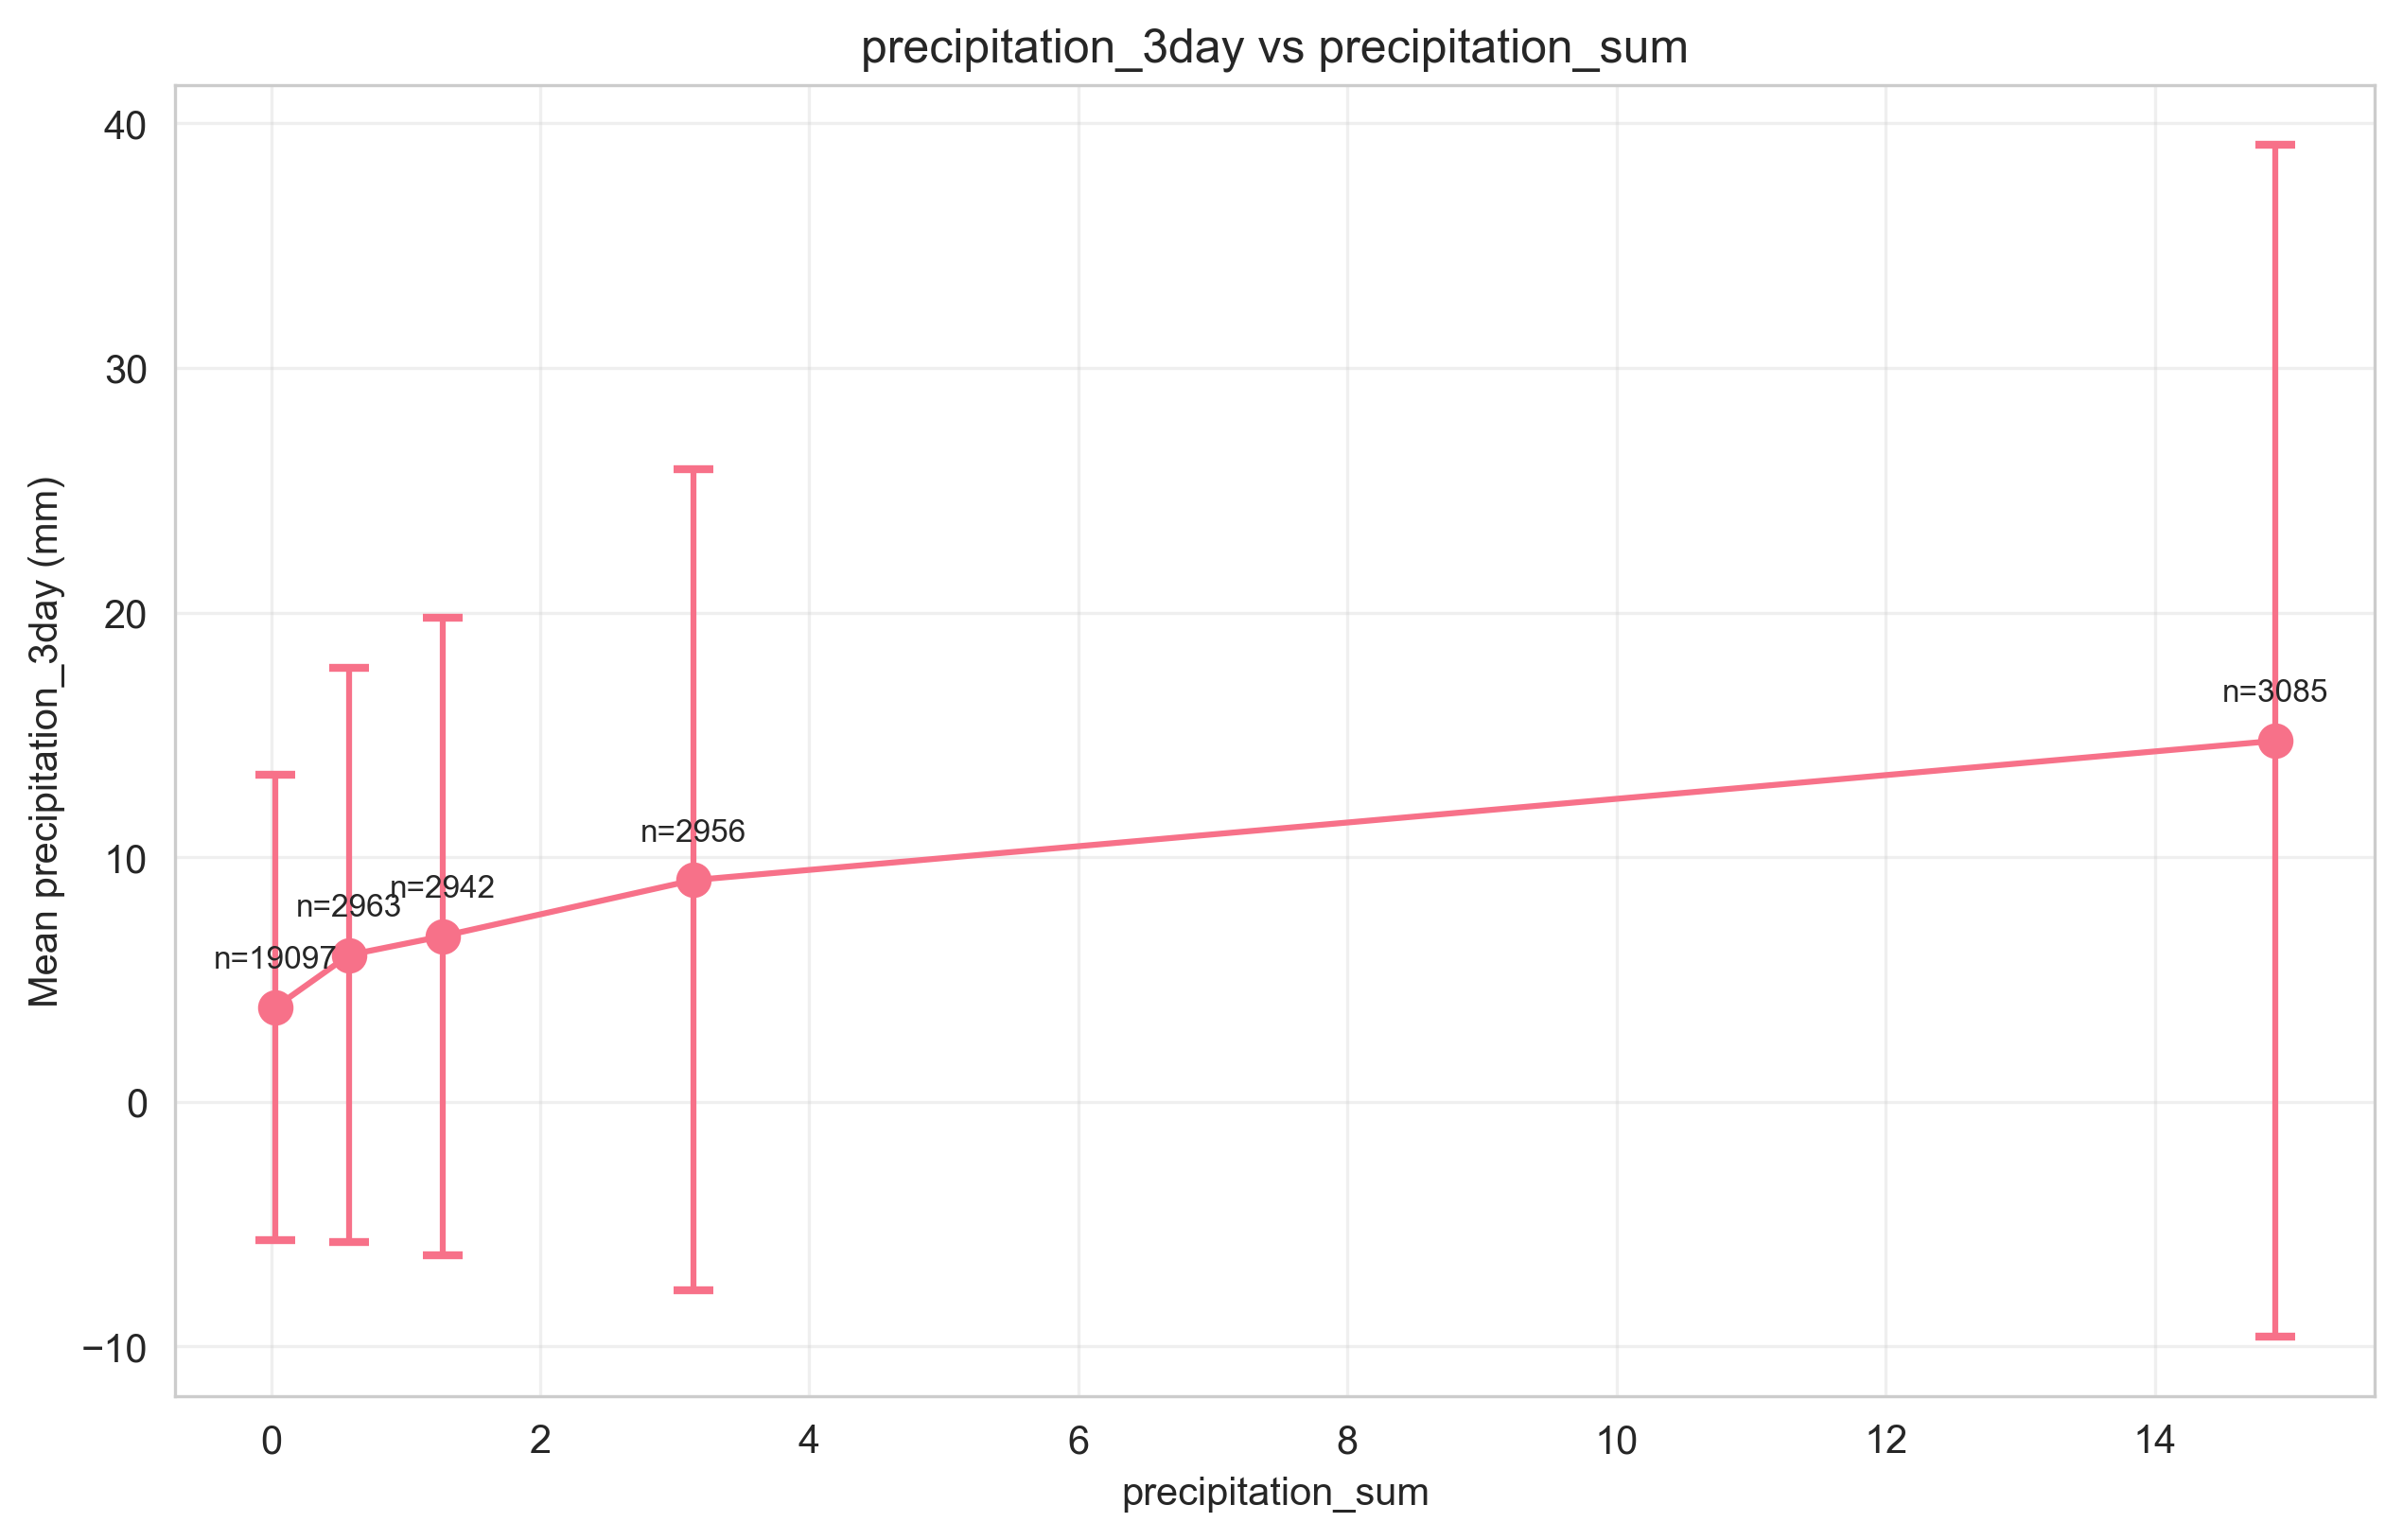

In [21]:
# Explore precipitation_sum feature for regression using weather module
fig = weather.plot_feature_vs_target_regression(
    df, 
    feature_col='precipitation_sum',
    target_col=target_name,
    n_bins=10,
    figsize=(10, 6)
)

In [22]:
# <Student to fill this section>
feature_1_insights = """
Current precipitation demonstrates moderate positive relationship with future accumulation. Weather system 
persistence partially explains three-day rainfall patterns. Considerable scatter indicates multiple factors 
influence precipitation beyond current conditions alone.
"""

In [23]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `<temperature_2m_mean>`

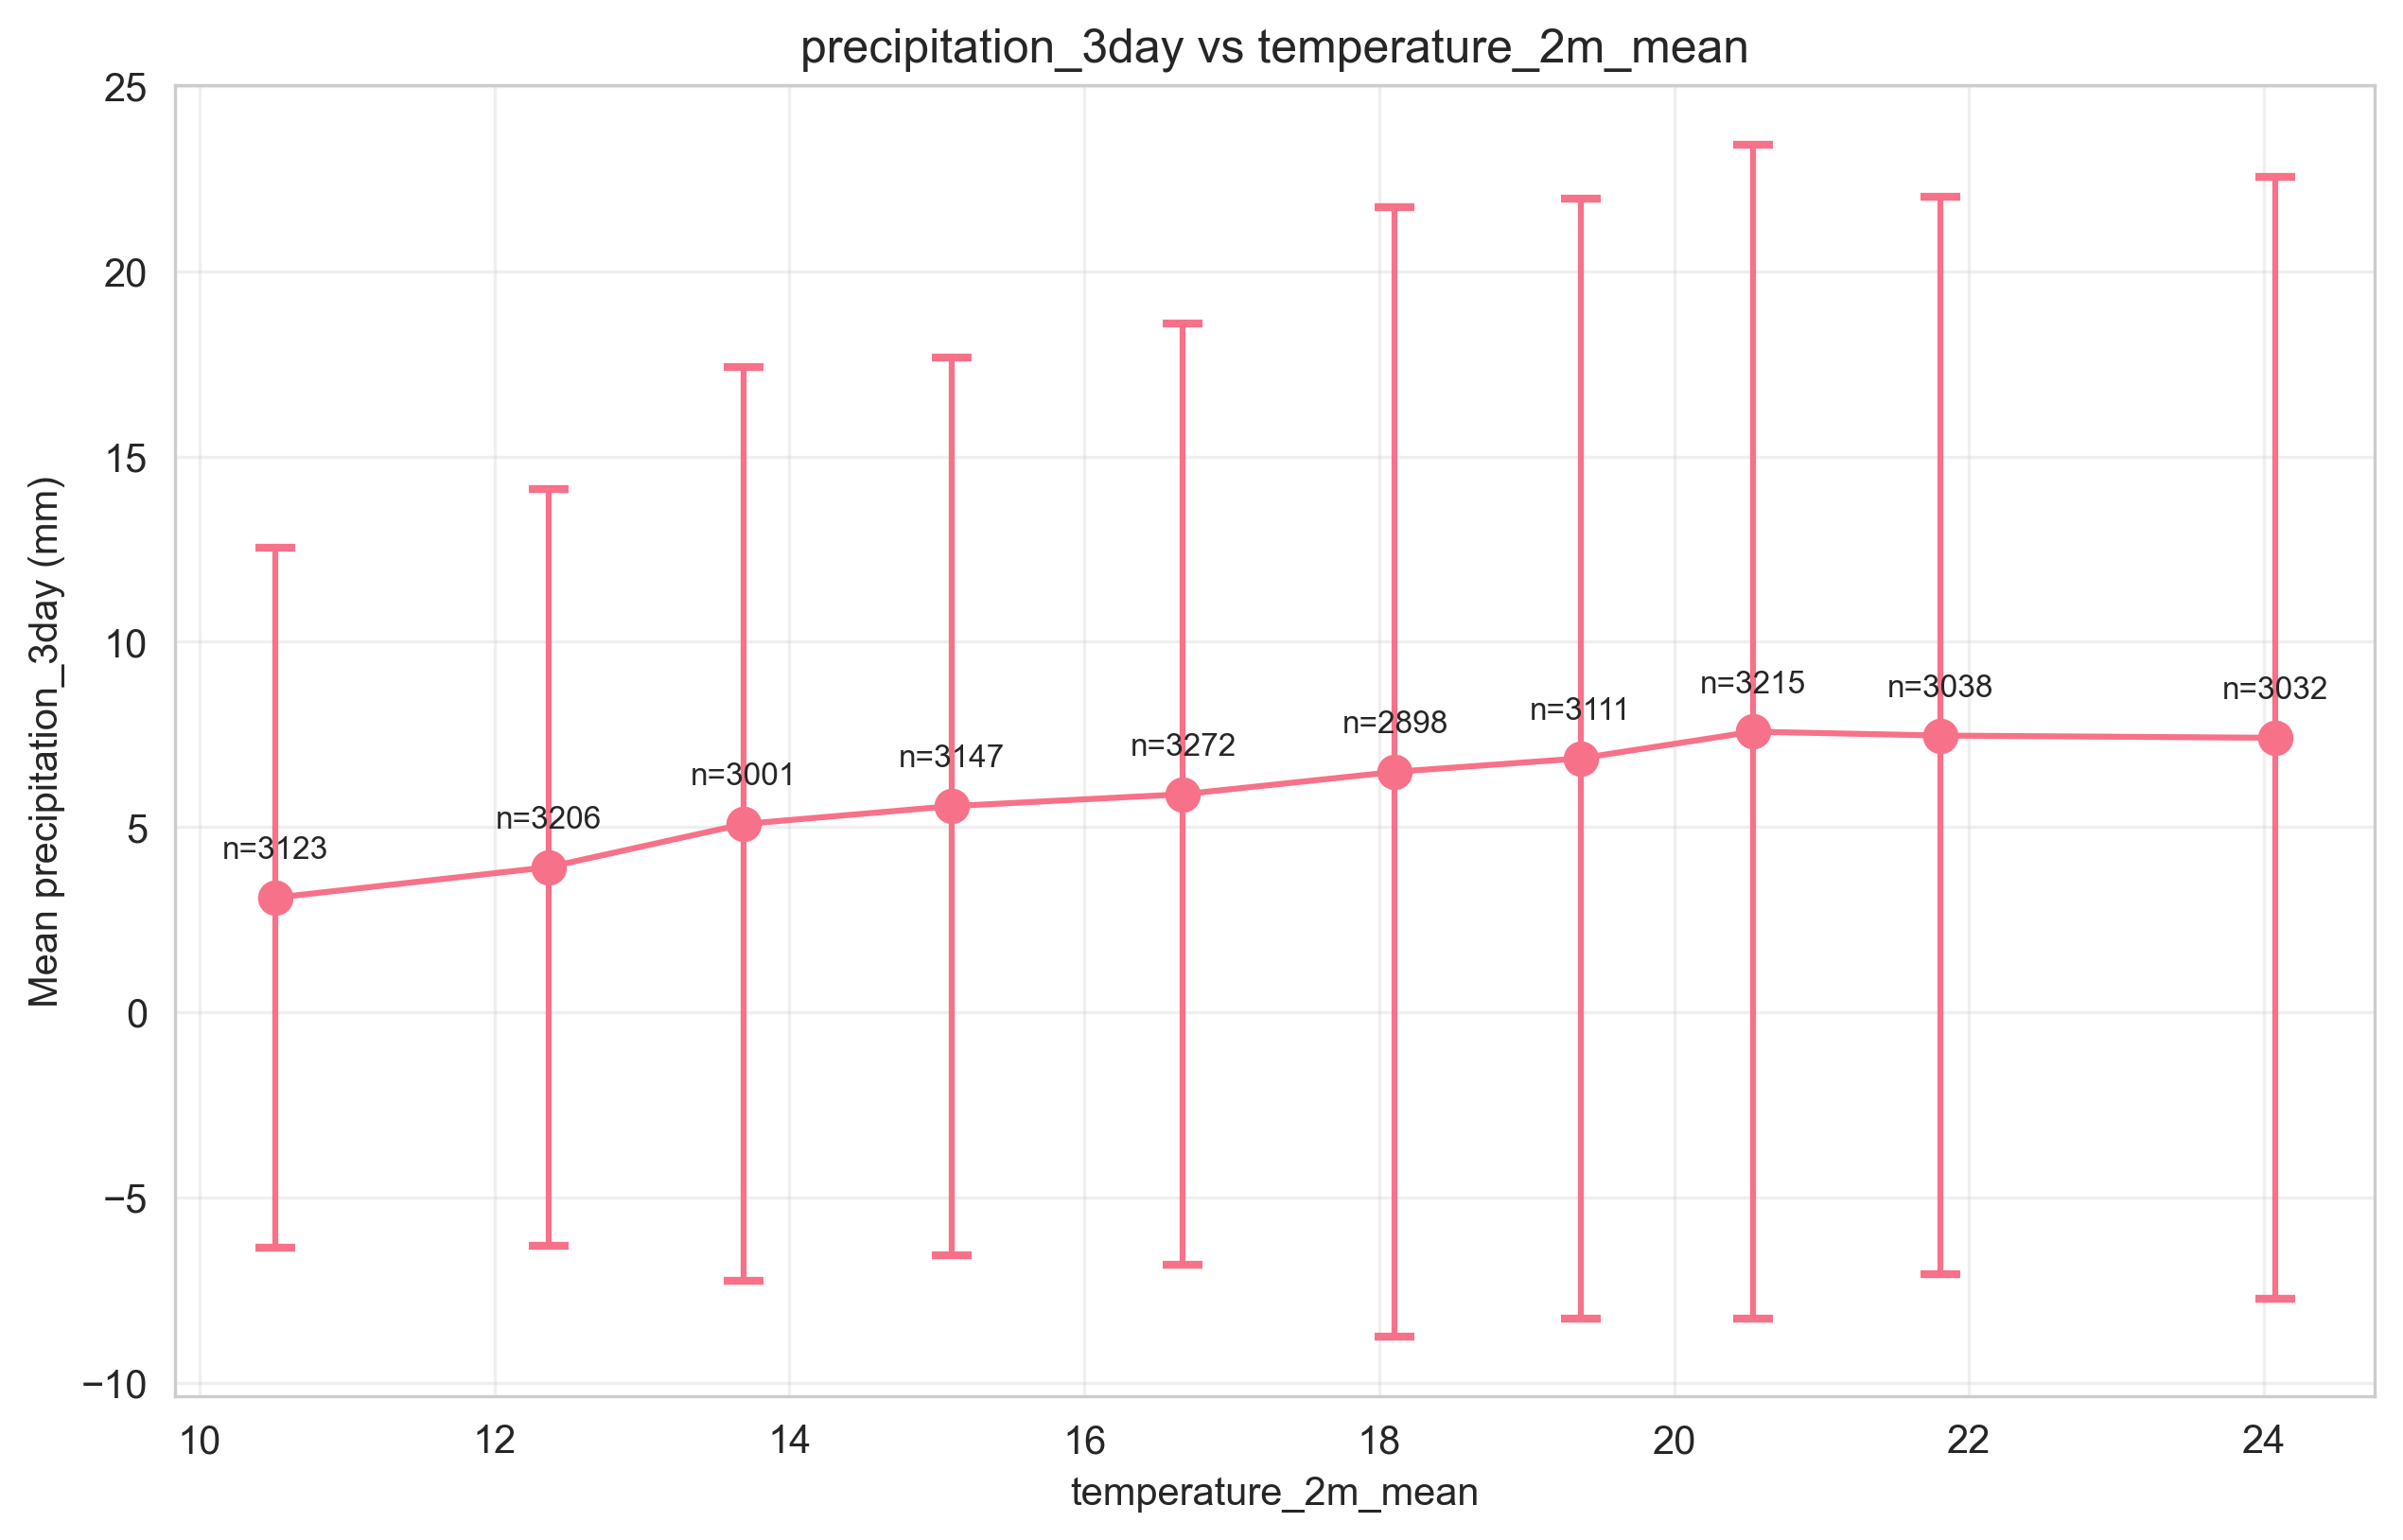

In [24]:
# Explore temperature_2m_mean feature for regression using weather module
fig = weather.plot_feature_vs_target_regression(
    df,
    feature_col='temperature_2m_mean',
    target_col=target_name,
    n_bins=10,
    figsize=(10, 6)
)

In [25]:
# <Student to fill this section>
feature_2_insights = """
Temperature inversely correlates with precipitation volumes reflecting seasonal patterns. Cooler conditions 
associate with increased rainfall accumulation. Relationship captures winter's higher precipitation compared 
to drier summer months in Sydney climate.
"""

In [26]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### D.1 Approach "Correlation Analysis"

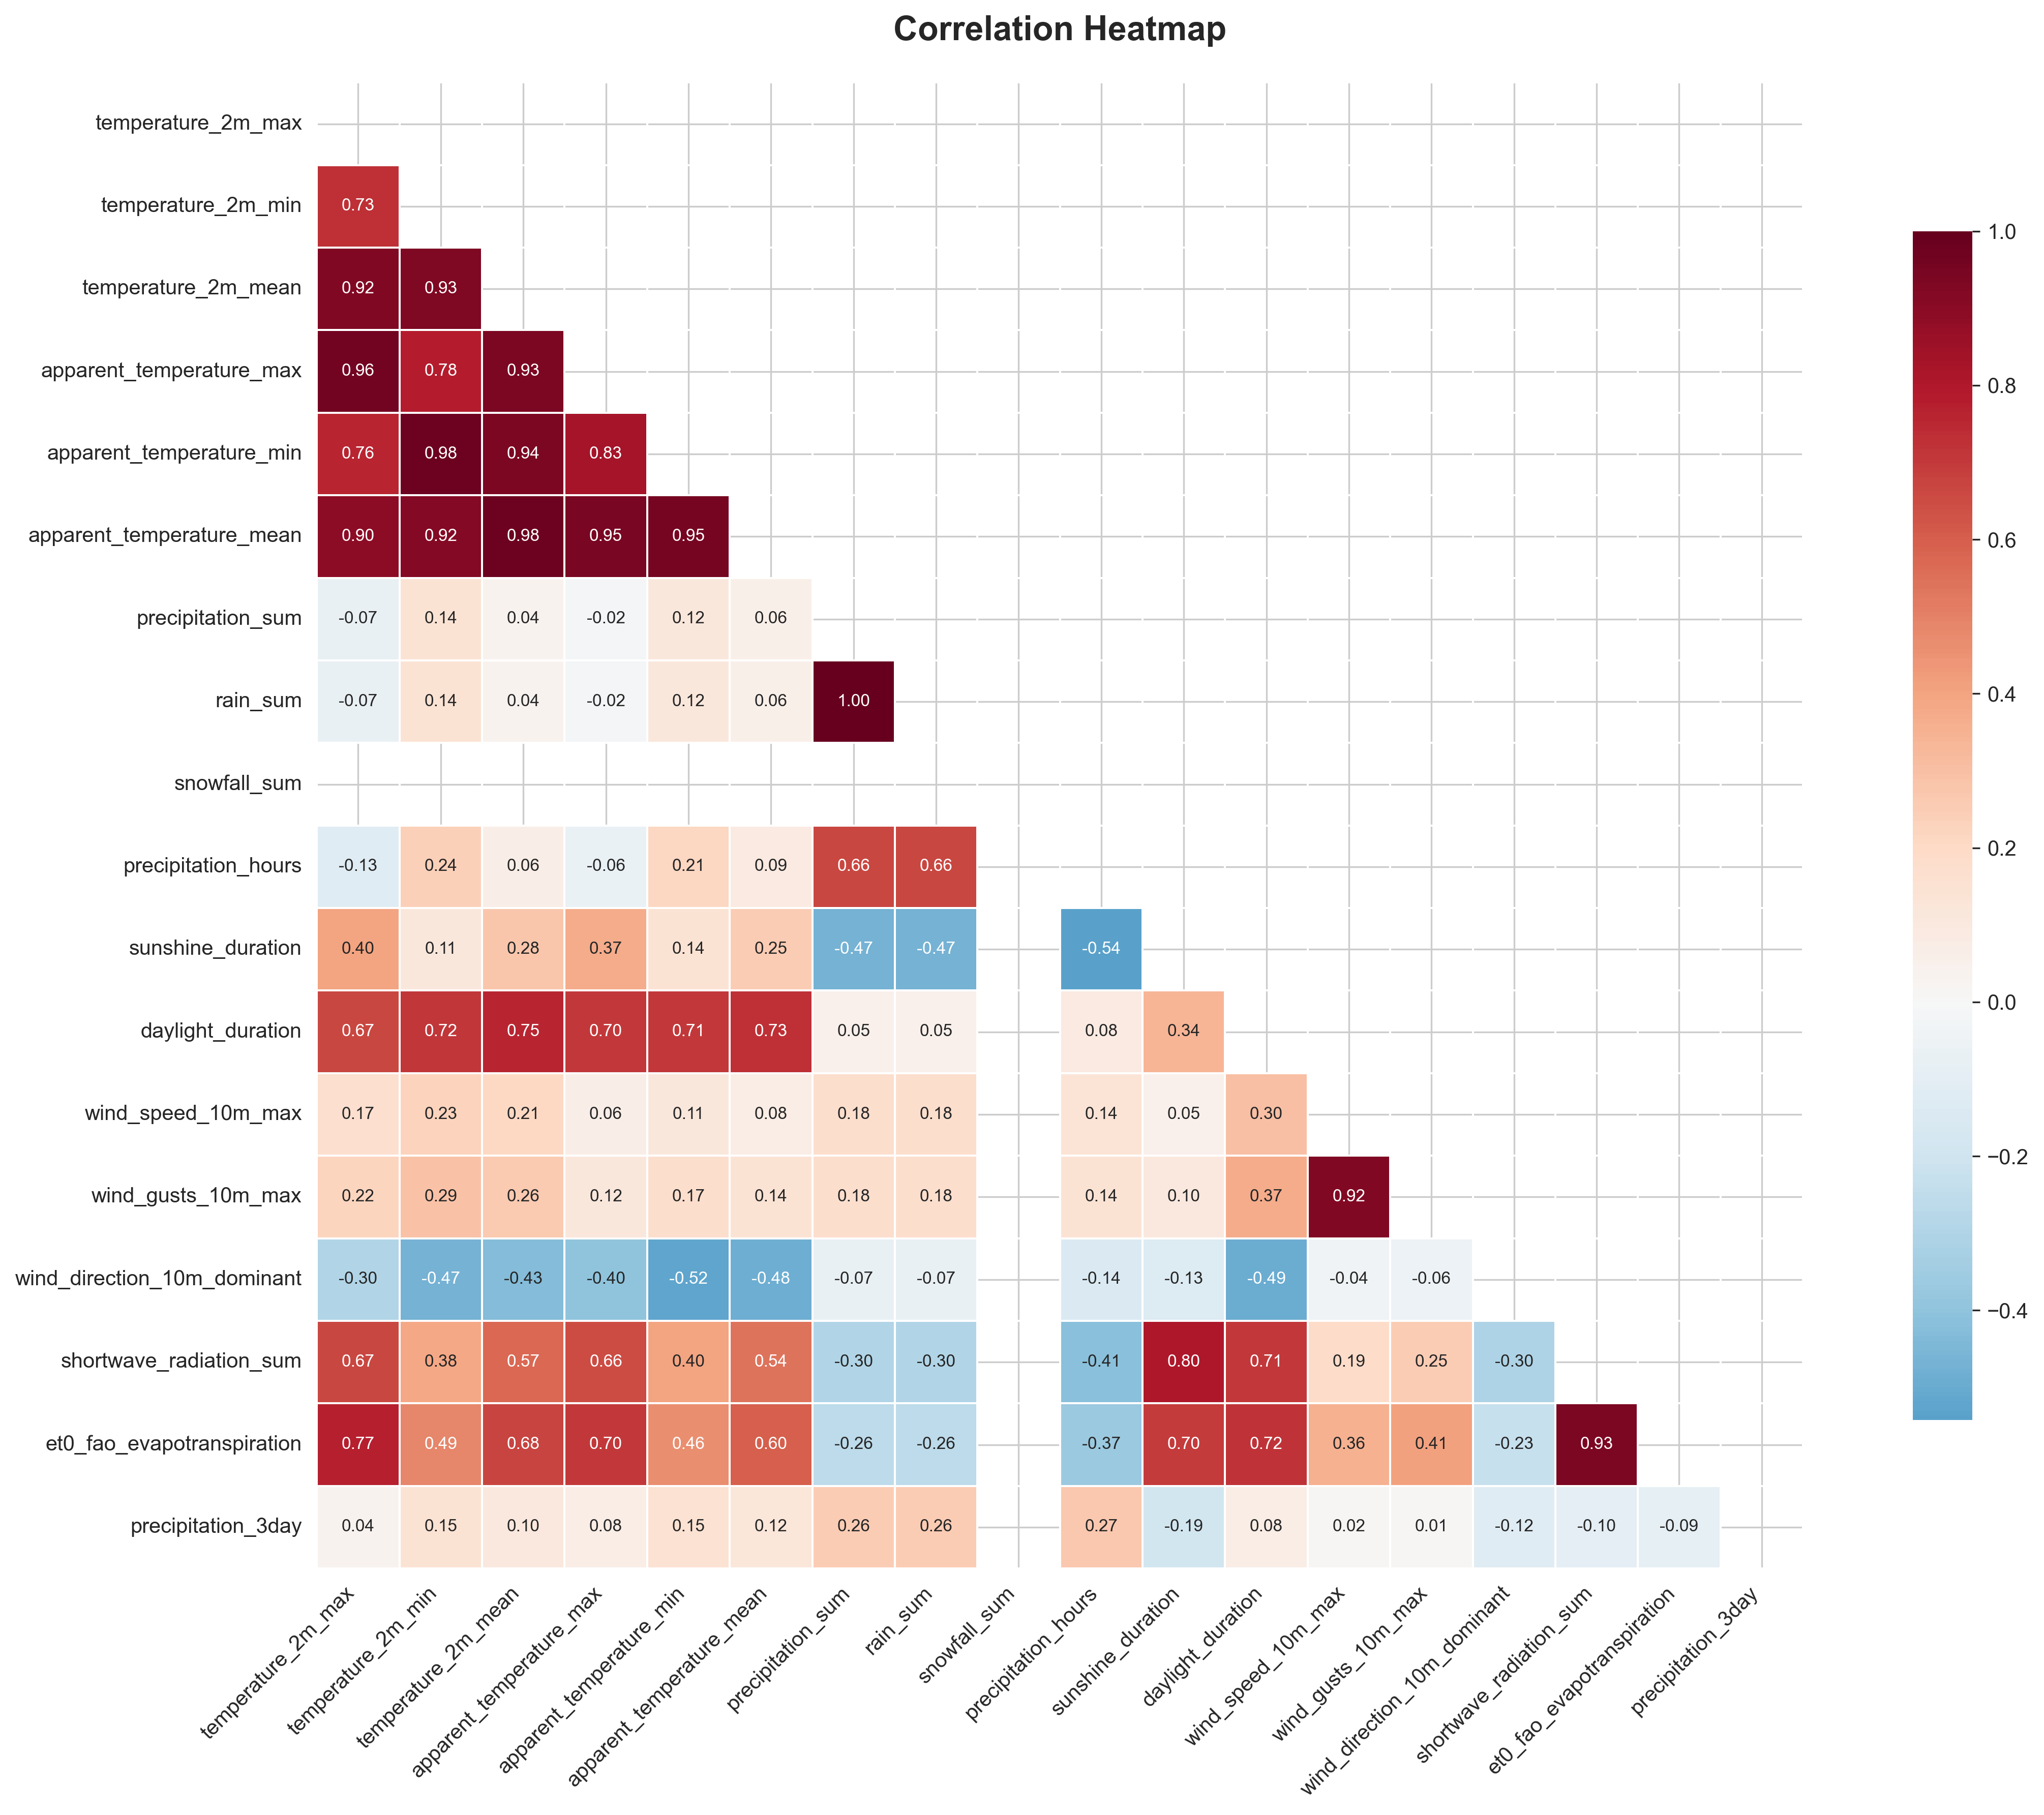

In [27]:
# Create correlation heatmap using weather module
fig = weather.plot_correlation_heatmap(
    df,
    exclude_cols=['weather_code']  # Exclude categorical variable
)

In [28]:
# <Student to fill this section>
feature_selection_1_insights = """
Correlation analysis reveals modest linear relationships between features and target. Precipitation-related 
variables show strongest associations while temperature exhibits inverse correlations. Weak overall correlations 
indicate non-linear methods may better capture precipitation dynamics.
"""

In [29]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "Feature Importance Analysis"

Top 10 features by absolute correlation:
precipitation_hours: 0.2710
precipitation_sum: 0.2579
rain_sum: 0.2579
sunshine_duration: 0.1882
apparent_temperature_min: 0.1535
temperature_2m_min: 0.1475
apparent_temperature_mean: 0.1244
wind_direction_10m_dominant: 0.1228
temperature_2m_mean: 0.1049
shortwave_radiation_sum: 0.0991


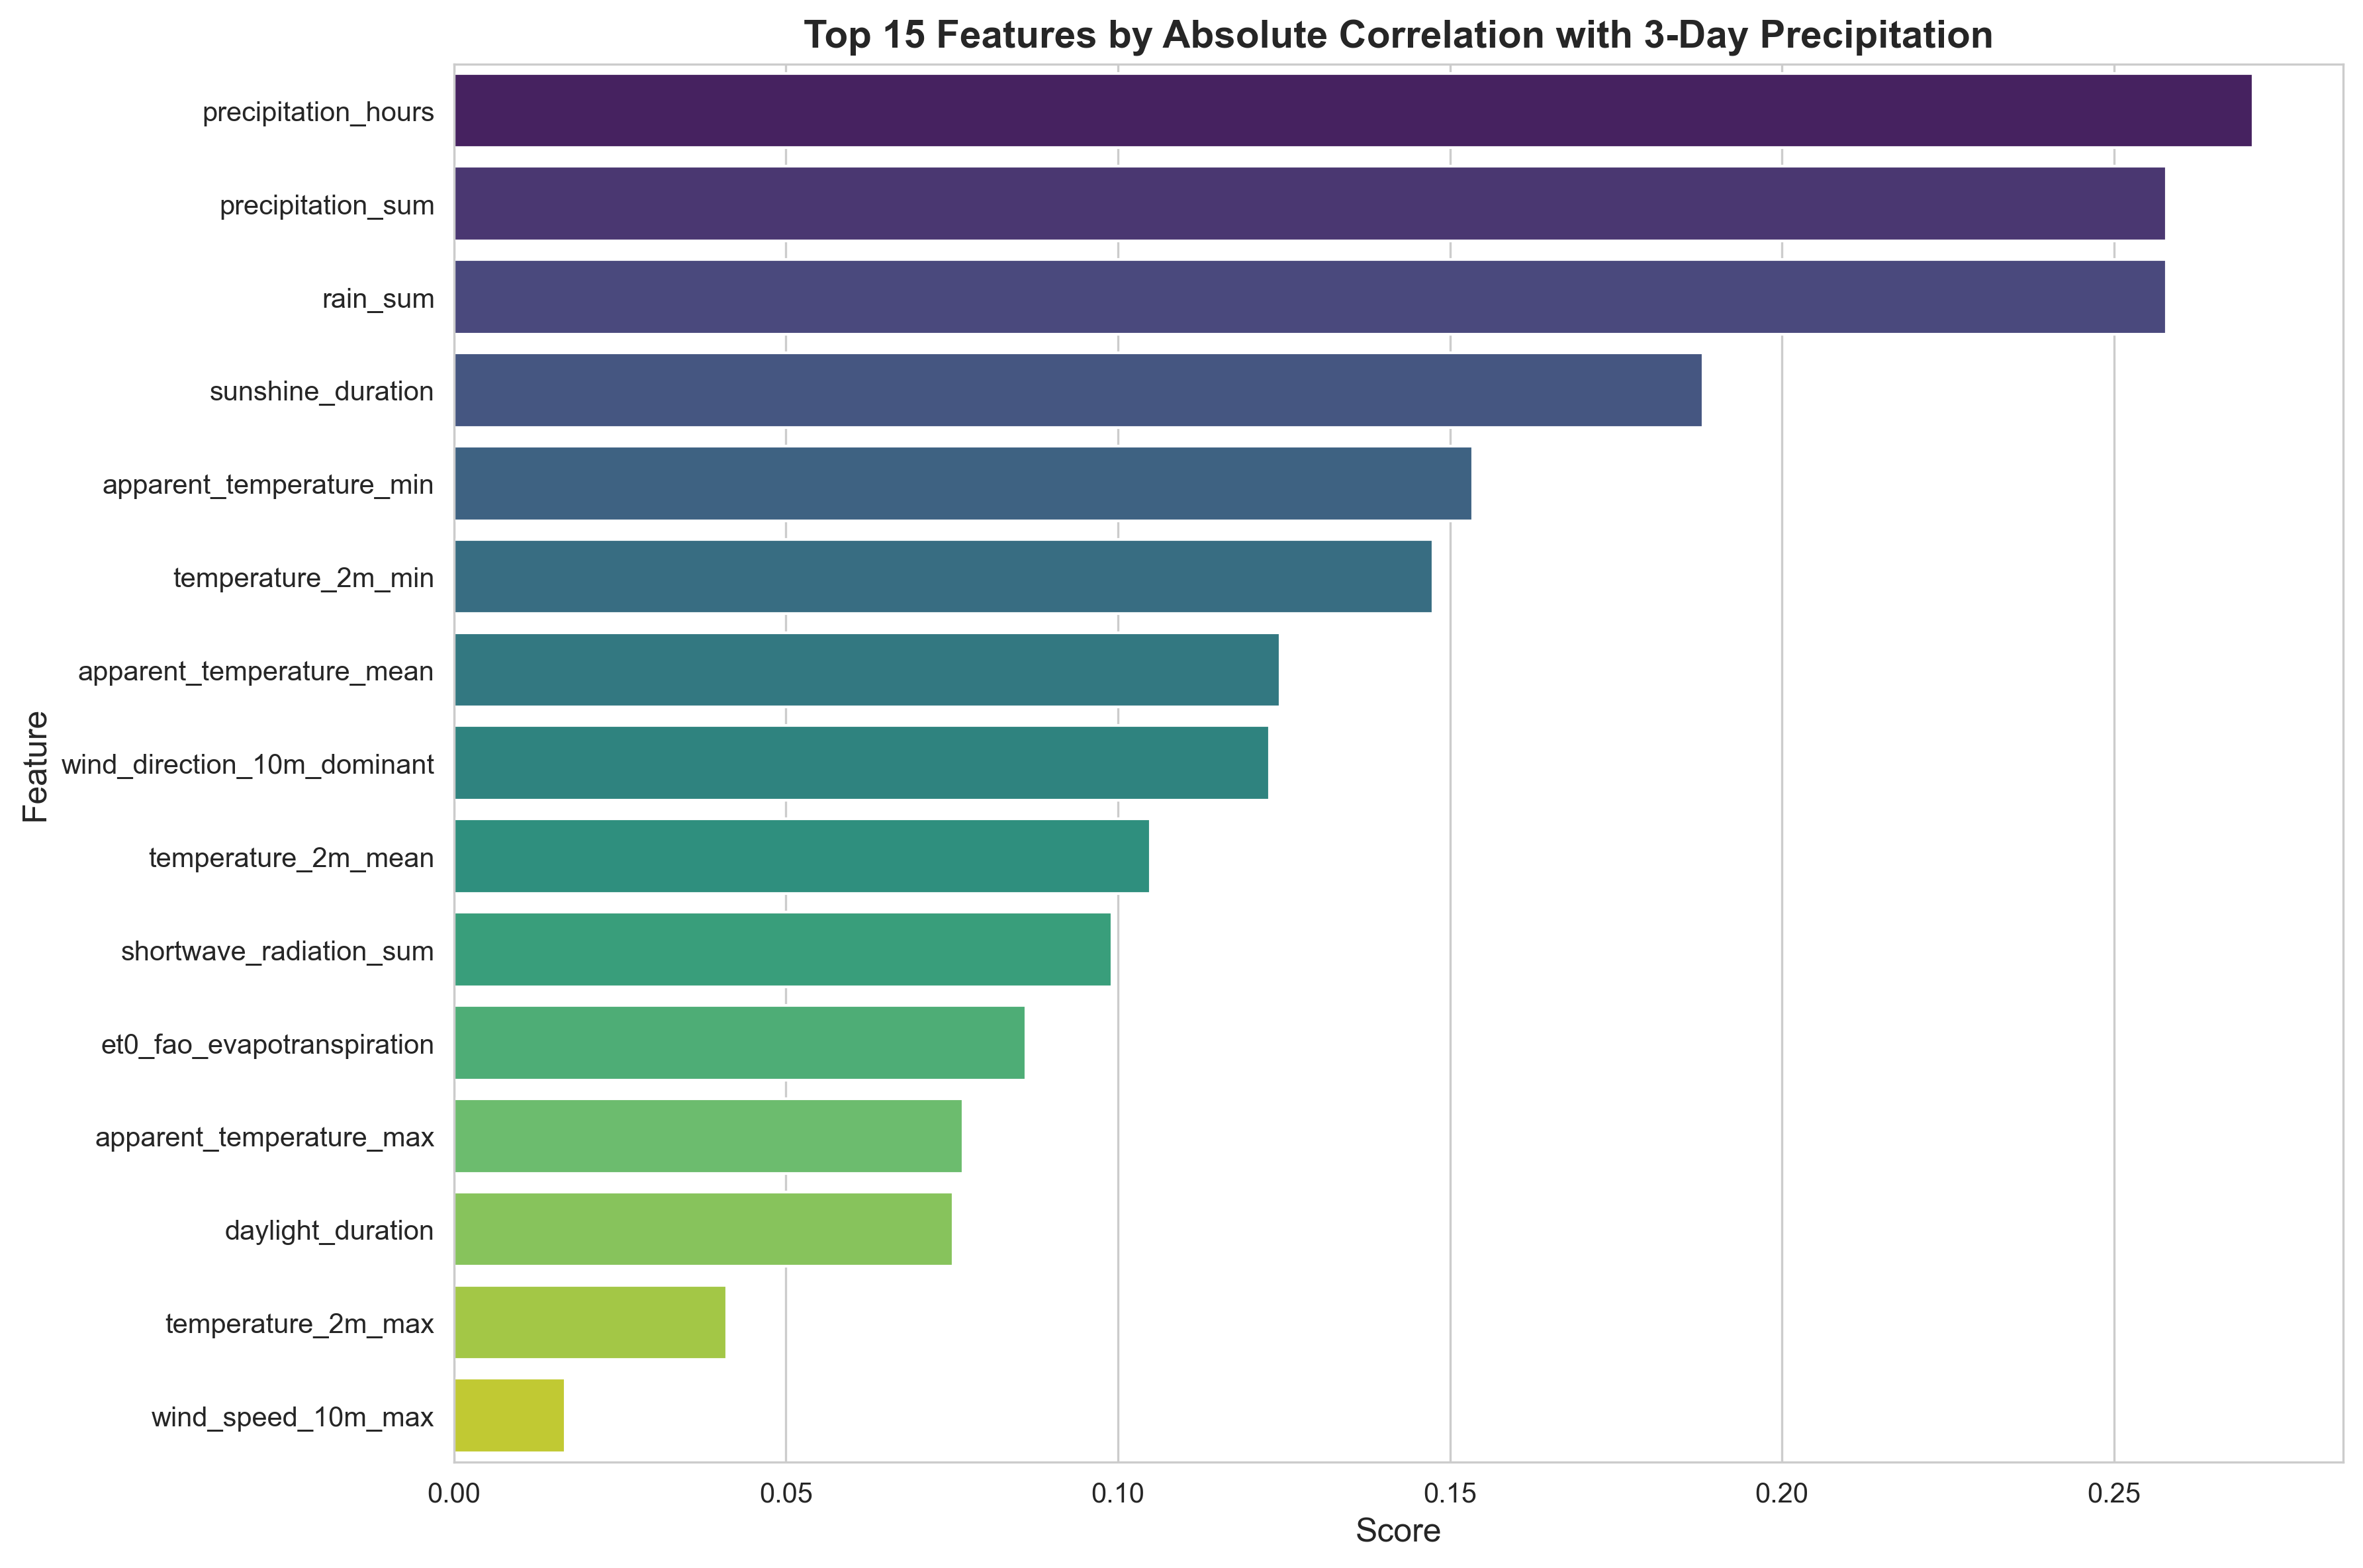

In [30]:
# Feature Importance Analysis using correlation for regression
# Prepare data for correlation analysis
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != target_name and f != 'weather_code']

# Calculate absolute correlations with target
correlations = df[numeric_features].corrwith(df[target_name]).abs()

# Create DataFrame for visualization
corr_df = pd.DataFrame({
    'feature': correlations.index,
    'score': correlations.values
}).sort_values('score', ascending=False)

# Visualize using weather module
fig = weather.plot_feature_importance(
    corr_df,
    score_col='score',
    feature_col='feature',
    top_n=15,
    title='Top 15 Features by Absolute Correlation with 3-Day Precipitation'
)

# Print top features
print("Top 10 features by absolute correlation:")
for idx, row in corr_df.head(10).iterrows():
    print(f"{row['feature']}: {row['score']:.4f}")

In [31]:
# <Student to fill this section>
feature_selection_2_insights = """
Precipitation hours emerges as most informative feature followed by actual precipitation measurements. 
Sunshine duration and temperature variables provide secondary importance. Wind direction unexpectedly relevant 
suggesting weather system movement influences rainfall patterns.
"""

In [32]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

## D.z Final Selection of Features

In [33]:
# Select features using weather module function for precipitation regression
features_list = weather.get_precipitation_feature_list(df, target_name)

print(f"Selected {len(features_list)} features:")
print(features_list)

Selected 16 features:
['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'precipitation_sum', 'precipitation_hours', 'sunshine_duration', 'daylight_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration']


In [34]:
feature_selection_explanations = """
Feature set excludes redundant variables like rain sum and snowfall. Retained precipitation hours showing 
highest predictive value. Comprehensive selection captures atmospheric conditions, temperature patterns and 
wind dynamics influencing precipitation accumulation.
"""

In [35]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation "Missing Values Check"

In [36]:
# Check for missing values
print("Missing values per column:")
print(df[features_list + [target_name]].isnull().sum()[df[features_list + [target_name]].isnull().sum() > 0])

# The target has missing values due to the 7-day shift
# Remove rows with missing target values
df_clean = df.dropna(subset=[target_name])

print(f"\nOriginal dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

Missing values per column:
Series([], dtype: int64)

Original dataset size: 31043
Clean dataset size: 31043
Rows removed: 0


In [37]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Dataset demonstrates exceptional quality without missing values. Comprehensive weather records spanning decades 
provide robust training foundation. Clean data enables immediate model development without preprocessing 
complications or imputation requirements.
"""

In [38]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

### F.1 New Feature "Month"

In [39]:
# Extract month feature using weather module function
df = weather.extract_month_feature(df)

# Update features list to use month instead of time
features_list = weather.get_feature_list(df, target_name)

# Display the month distribution
print("Month distribution in the dataset:")
print(df['month'].value_counts().sort_index())
print(f"\nTotal features: {len(features_list)}")
print(f"\nUpdated features list (first 10): {features_list[:10]}")

Month distribution in the dataset:
month
April        2550
August       2635
December     2632
February     2402
January      2634
July         2635
June         2550
March        2635
May          2635
November     2550
October      2635
September    2550
Name: count, dtype: int64

Total features: 17

Updated features list (first 10): ['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'rain_sum', 'precipitation_hours', 'sunshine_duration']


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


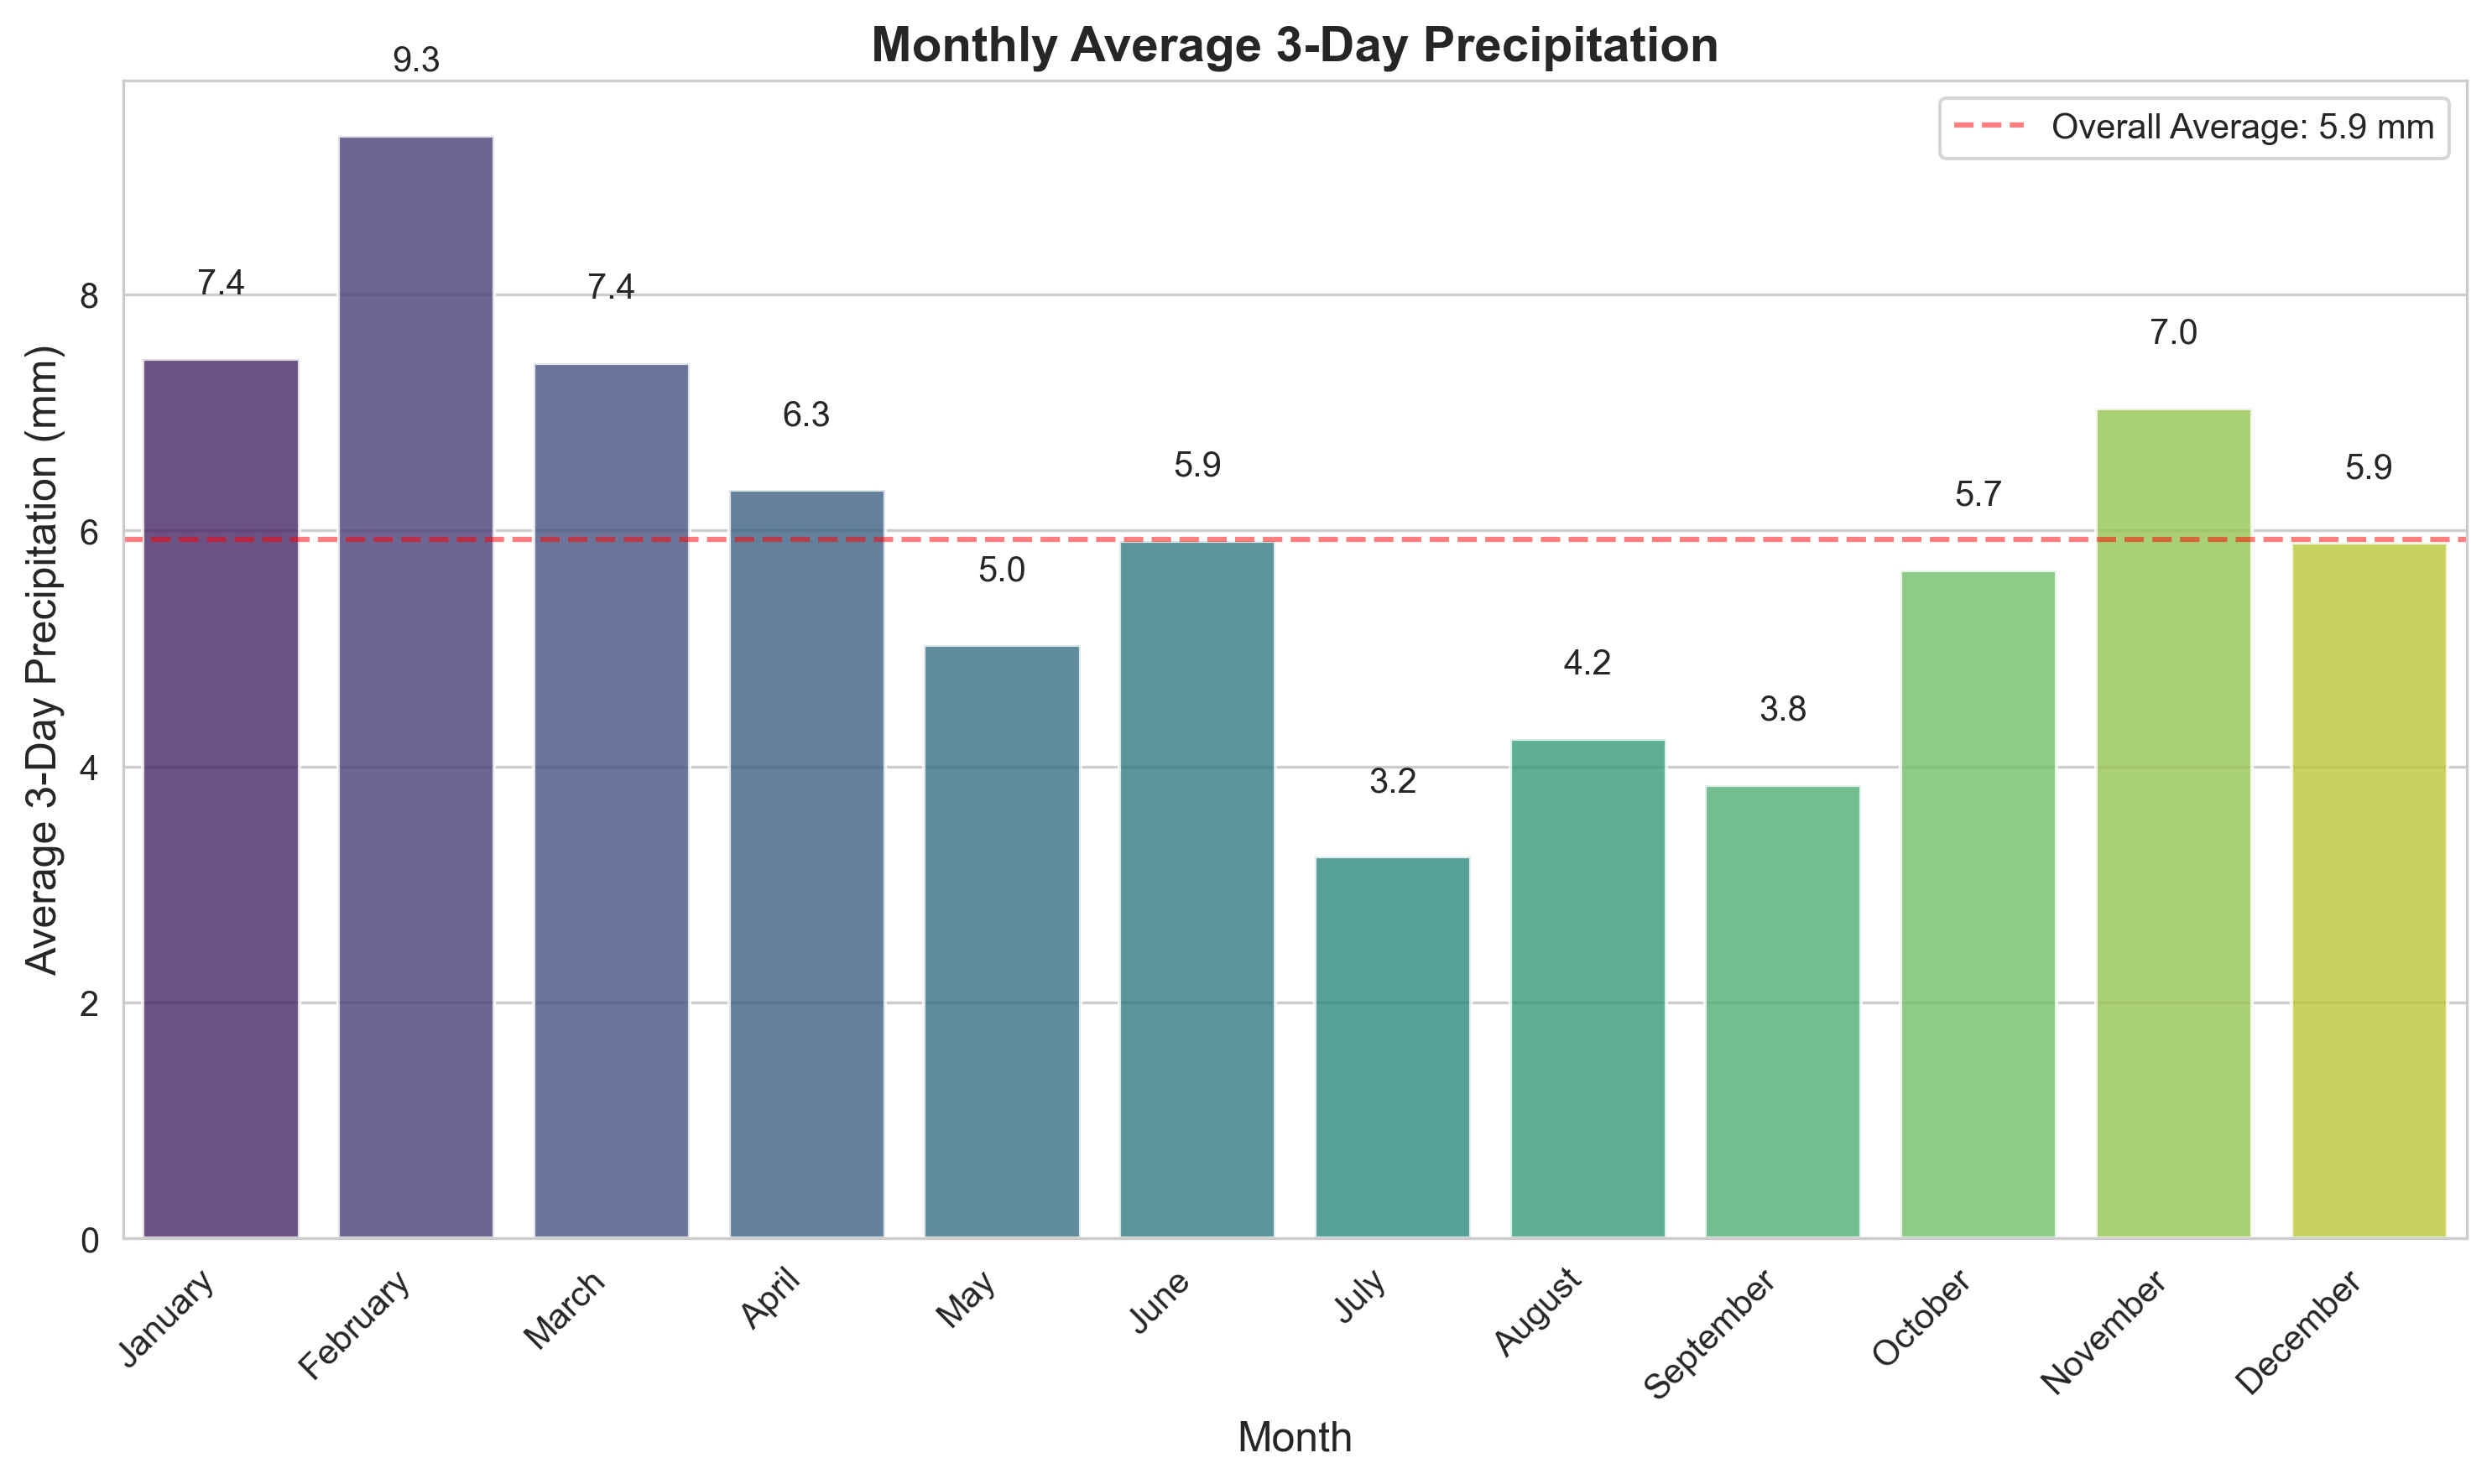

In [40]:
# Visualize monthly precipitation patterns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate monthly average precipitation
monthly_avg = df.groupby('month')[target_name].mean()

# Define month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Reorder data
monthly_avg = monthly_avg.reindex(month_order)

# Create bar plot
import seaborn as sns
sns.barplot(x=month_order, y=monthly_avg.values, 
            palette='viridis', alpha=0.8, ax=ax)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average 3-Day Precipitation (mm)', fontsize=12)
ax.set_title('Monthly Average 3-Day Precipitation', fontsize=14, fontweight='bold')

# Add value labels
for i, (month, value) in enumerate(zip(month_order, monthly_avg.values)):
    ax.text(i, value + 0.5, f'{value:.1f}', 
            ha='center', va='bottom', fontsize=10)

# Add overall average line
overall_avg = df[target_name].mean()
ax.axhline(y=overall_avg, color='red', linestyle='--', alpha=0.5, 
           label=f'Overall Average: {overall_avg:.1f} mm')
ax.legend()

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [41]:
feature_engineering_1_explanations = """
Monthly precipitation patterns reveal strong seasonal variations. Winter months demonstrate substantially higher 
average rainfall while summer remains relatively dry. Categorical month feature enables model to capture 
cyclical weather patterns improving predictions.
"""

In [42]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [43]:
# Split data using weather module function for regression
X = df[features_list]
y = df[target_name]

# Use the weather module's train_val_test_split function (no stratification for regression)
from sklearn.model_selection import train_test_split

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2 overall
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check target distribution in each set
print(f"\nTarget statistics:")
print(f"Train - Mean: {y_train.mean():.2f} mm, Std: {y_train.std():.2f} mm")
print(f"Val - Mean: {y_val.mean():.2f} mm, Std: {y_val.std():.2f} mm")
print(f"Test - Mean: {y_test.mean():.2f} mm, Std: {y_test.std():.2f} mm")

# Print column names
print(f"\nColumns in X_train: {X_train.columns.tolist()}")
print(f"Number of columns: {len(X_train.columns)}")

Training set size: 18625 (60.0%)
Validation set size: 6209 (20.0%)
Test set size: 6209 (20.0%)

Target statistics:
Train - Mean: 5.94 mm, Std: 13.86 mm
Val - Mean: 5.63 mm, Std: 12.14 mm
Test - Mean: 6.18 mm, Std: 13.66 mm

Columns in X_train: ['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'rain_sum', 'precipitation_hours', 'sunshine_duration', 'daylight_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'month']
Number of columns: 17


In [44]:
data_splitting_explanations = """
Training, validation and test sets maintain comparable precipitation distributions. Random splitting ensures 
unbiased evaluation across partitions. Consistent target statistics confirm proper data division enabling 
reliable model assessment.
"""

In [45]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "LightGBM Native Features for Regression"

In [46]:
# LightGBM native categorical feature handling (no one-hot encoding or standardization needed)
# Split features by type using weather module function
categorical_features, numerical_features = weather.split_features_by_type(features_list)

print(f"Categorical features: {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features[:5]}...")

# Convert categorical features to 'category' dtype for LightGBM
for cat_col in categorical_features:
    X_train[cat_col] = X_train[cat_col].astype('category')
    X_val[cat_col] = X_val[cat_col].astype('category')
    X_test[cat_col] = X_test[cat_col].astype('category')

print(f"\nFinal shape - X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"Total features: {len(features_list)}")
print("\nNote: LightGBM handles categorical features natively - no one-hot encoding needed!")

Categorical features: ['month', 'weather_code']
Numerical features (15): ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min']...

Final shape - X_train: (18625, 17), X_val: (6209, 17), X_test: (6209, 17)
Total features: 17

Note: LightGBM handles categorical features natively - no one-hot encoding needed!


In [47]:
data_transformation_1_explanations = """
LightGBM processes categorical features natively eliminating encoding requirements. Direct categorical handling 
preserves information while reducing dimensionality. No scaling needed as tree-based methods remain invariant 
to feature magnitudes.
"""

In [48]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

In [49]:
# Save processed data to data/processed directory with exp_4 suffix for precipitation regression

# Create processed data directory if it doesn't exist
processed_path = '../../data/processed/'
os.makedirs(processed_path, exist_ok=True)

# Save the processed datasets with exp_4 suffix (LightGBM format for precipitation)
X_train.to_csv(os.path.join(processed_path, 'X_train_exp_4.csv'), index=False)
X_val.to_csv(os.path.join(processed_path, 'X_val_exp_4.csv'), index=False)
X_test.to_csv(os.path.join(processed_path, 'X_test_exp_4.csv'), index=False)
y_train.to_csv(os.path.join(processed_path, 'y_train_exp_4.csv'), index=False, header=['precipitation_3day'])
y_val.to_csv(os.path.join(processed_path, 'y_val_exp_4.csv'), index=False, header=['precipitation_3day'])
y_test.to_csv(os.path.join(processed_path, 'y_test_exp_4.csv'), index=False, header=['precipitation_3day'])

print(f"Processed data saved to {processed_path}:")
print(f"  - X_train_exp_4.csv: {X_train.shape}")
print(f"  - X_val_exp_4.csv: {X_val.shape}")
print(f"  - X_test_exp_4.csv: {X_test.shape}")
print(f"  - y_train_exp_4.csv: {y_train.shape}")
print(f"  - y_val_exp_4.csv: {y_val.shape}")
print(f"  - y_test_exp_4.csv: {y_test.shape}")

Processed data saved to ../../data/processed/:
  - X_train_exp_4.csv: (18625, 17)
  - X_val_exp_4.csv: (6209, 17)
  - X_test_exp_4.csv: (6209, 17)
  - y_train_exp_4.csv: (18625,)
  - y_val_exp_4.csv: (6209,)
  - y_test_exp_4.csv: (6209,)


---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [50]:
# <Student to fill this section>
primary_metric = 'RMSE'

In [51]:
performance_metrics_explanations = """
RMSE measures prediction error in millimeters providing interpretable assessment of volumetric accuracy. Lower RMSE 
indicates better model performance with predictions closer to actual precipitation values. Metric directly relates 
to practical applications where prediction errors translate to water volume miscalculations.
"""

In [52]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [53]:
# use LightGBM for gradient boosting with native categorical support

In [54]:
algorithm_selection_explanations = """
LightGBM gradient boosting excels at regression tasks with mixed feature types. Tree ensembles capture non-linear 
relationships between weather variables and precipitation volumes. Native categorical handling and built-in regularization 
prevent overfitting while modeling complex precipitation patterns and extreme events.
"""

In [55]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [56]:
# Set constant hyperparameters for LightGBM Regression
# Note: Some parameters will be optimized separately
hyperparameters = {
    'objective': 'regression',       # Regression task
    'metric': 'rmse',               # Primary metric
    'boosting_type': 'gbdt',       # Gradient Boosting Decision Tree
    'verbose': -1,                  # Suppress output
    'seed': 32,                     # Random seed
    'force_col_wise': True          # Force column-wise histogram building
}

In [57]:
hyperparameters_selection_explanations = """
Regression objective optimizes squared error for continuous target. RMSE metric aligns with evaluation criteria. 
Column-wise histogram building optimizes memory for high-dimensional weather data. Tree depth and regularization 
parameters optimized through Bayesian search balancing model complexity with generalization.
"""

In [58]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [59]:
# Model training for LightGBM regression
set_verbosity(optuna.logging.WARNING)

# Get categorical features
categorical_features, _ = weather.split_features_by_type(X_train.columns.tolist())

# Convert categorical features to 'category' dtype
for cat_col in categorical_features:
    X_train[cat_col] = X_train[cat_col].astype('category')
    X_val[cat_col] = X_val[cat_col].astype('category')

# Prepare LightGBM datasets
train_data, val_data = weather.prepare_lightgbm_datasets(
    X_train, X_val, y_train, y_val, categorical_features
)

# Optimize LightGBM hyperparameters for regression
print(f"Optimizing LightGBM hyperparameters for {primary_metric}...")

# Define parameter space for optimization
param_space = {
    'num_leaves': ('int', 20, 300),
    'learning_rate': ('float', 0.01, 0.3, True),  # log=True
    'feature_fraction': ('float', 0.4, 1.0),
    'bagging_fraction': ('float', 0.4, 1.0),
    'bagging_freq': ('int', 1, 7),
    'lambda_l1': ('float', 1e-8, 10.0, True),
    'lambda_l2': ('float', 1e-8, 10.0, True),
}

best_params, best_score, model = weather.optimize_lightgbm_regression(
    train_data, val_data,
    fixed_params=hyperparameters,
    param_space=param_space,
    metric=primary_metric.lower(),
    n_trials=100
)

print(f"\nBest parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nBest validation {primary_metric}: {best_score:.4f}")
print(f"Best iteration: {model.best_iteration}")

# Calculate all metrics on validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
val_metrics = weather.calculate_regression_metrics(y_val, y_val_pred)

print(f"\nValidation Set Performance:")
for metric_name, metric_value in val_metrics.items():
    print(f"{metric_name.upper()}: {metric_value:.4f}")

Optimizing LightGBM hyperparameters for RMSE...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 11.4852
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 11.6888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 11.5068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 11.3953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 11.5763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 11.5457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 11.4084
Training until validation scores don't improve for 50 rounds
Early stopping, be

In [60]:
# Save the best model for precipitation regression
model_dir = '../../models/precipitation_fall/'

# Prepare model info
model_info = {
    'best_params': best_params,
    'final_params': {**hyperparameters, **best_params},
    'best_iteration': model.best_iteration,
    'primary_metric': primary_metric,
    'validation_metrics': val_metrics,
    'feature_names': X_train.columns.tolist(),
    'categorical_features': categorical_features
}

# Save model and info
model_path = os.path.join(model_dir, 'precipitation_lightgbm.txt')
info_path = os.path.join(model_dir, 'precipitation_lightgbm_info.json')

weather.save_model(
    model=model,
    model_path=model_path,
    model_info=model_info,
    info_path=info_path,
    model_type='lightgbm',
    best_iteration=model.best_iteration
)

Model saved to: ../../models/precipitation_fall/precipitation_lightgbm.txt
Model info saved to: ../../models/precipitation_fall/precipitation_lightgbm_info.json


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [61]:
# Evaluate model on test set using weather module function
# Convert categorical features in test set
for cat_col in categorical_features:
    if cat_col in X_test.columns:
        X_test[cat_col] = X_test[cat_col].astype('category')

test_metrics, report = weather.evaluate_regression_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    categorical_features=categorical_features,
    model_type='lightgbm',
    best_iteration=model.best_iteration
)

# Print the report
print(report)

# Get predictions for visualization
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)


REGRESSION MODEL EVALUATION - TEST SET
Root Mean Squared Error (RMSE): 12.8852
Mean Absolute Error (MAE):      6.5585
R-squared (R²):                 0.1106
Mean Squared Error (MSE):       166.0274

Additional Statistics:
Mean of predictions:     5.9870
Std of predictions:      4.5543
Mean of actual values:   6.1757
Std of actual values:    13.6631
Mean residual:          0.1887
Std of residuals:       12.8838



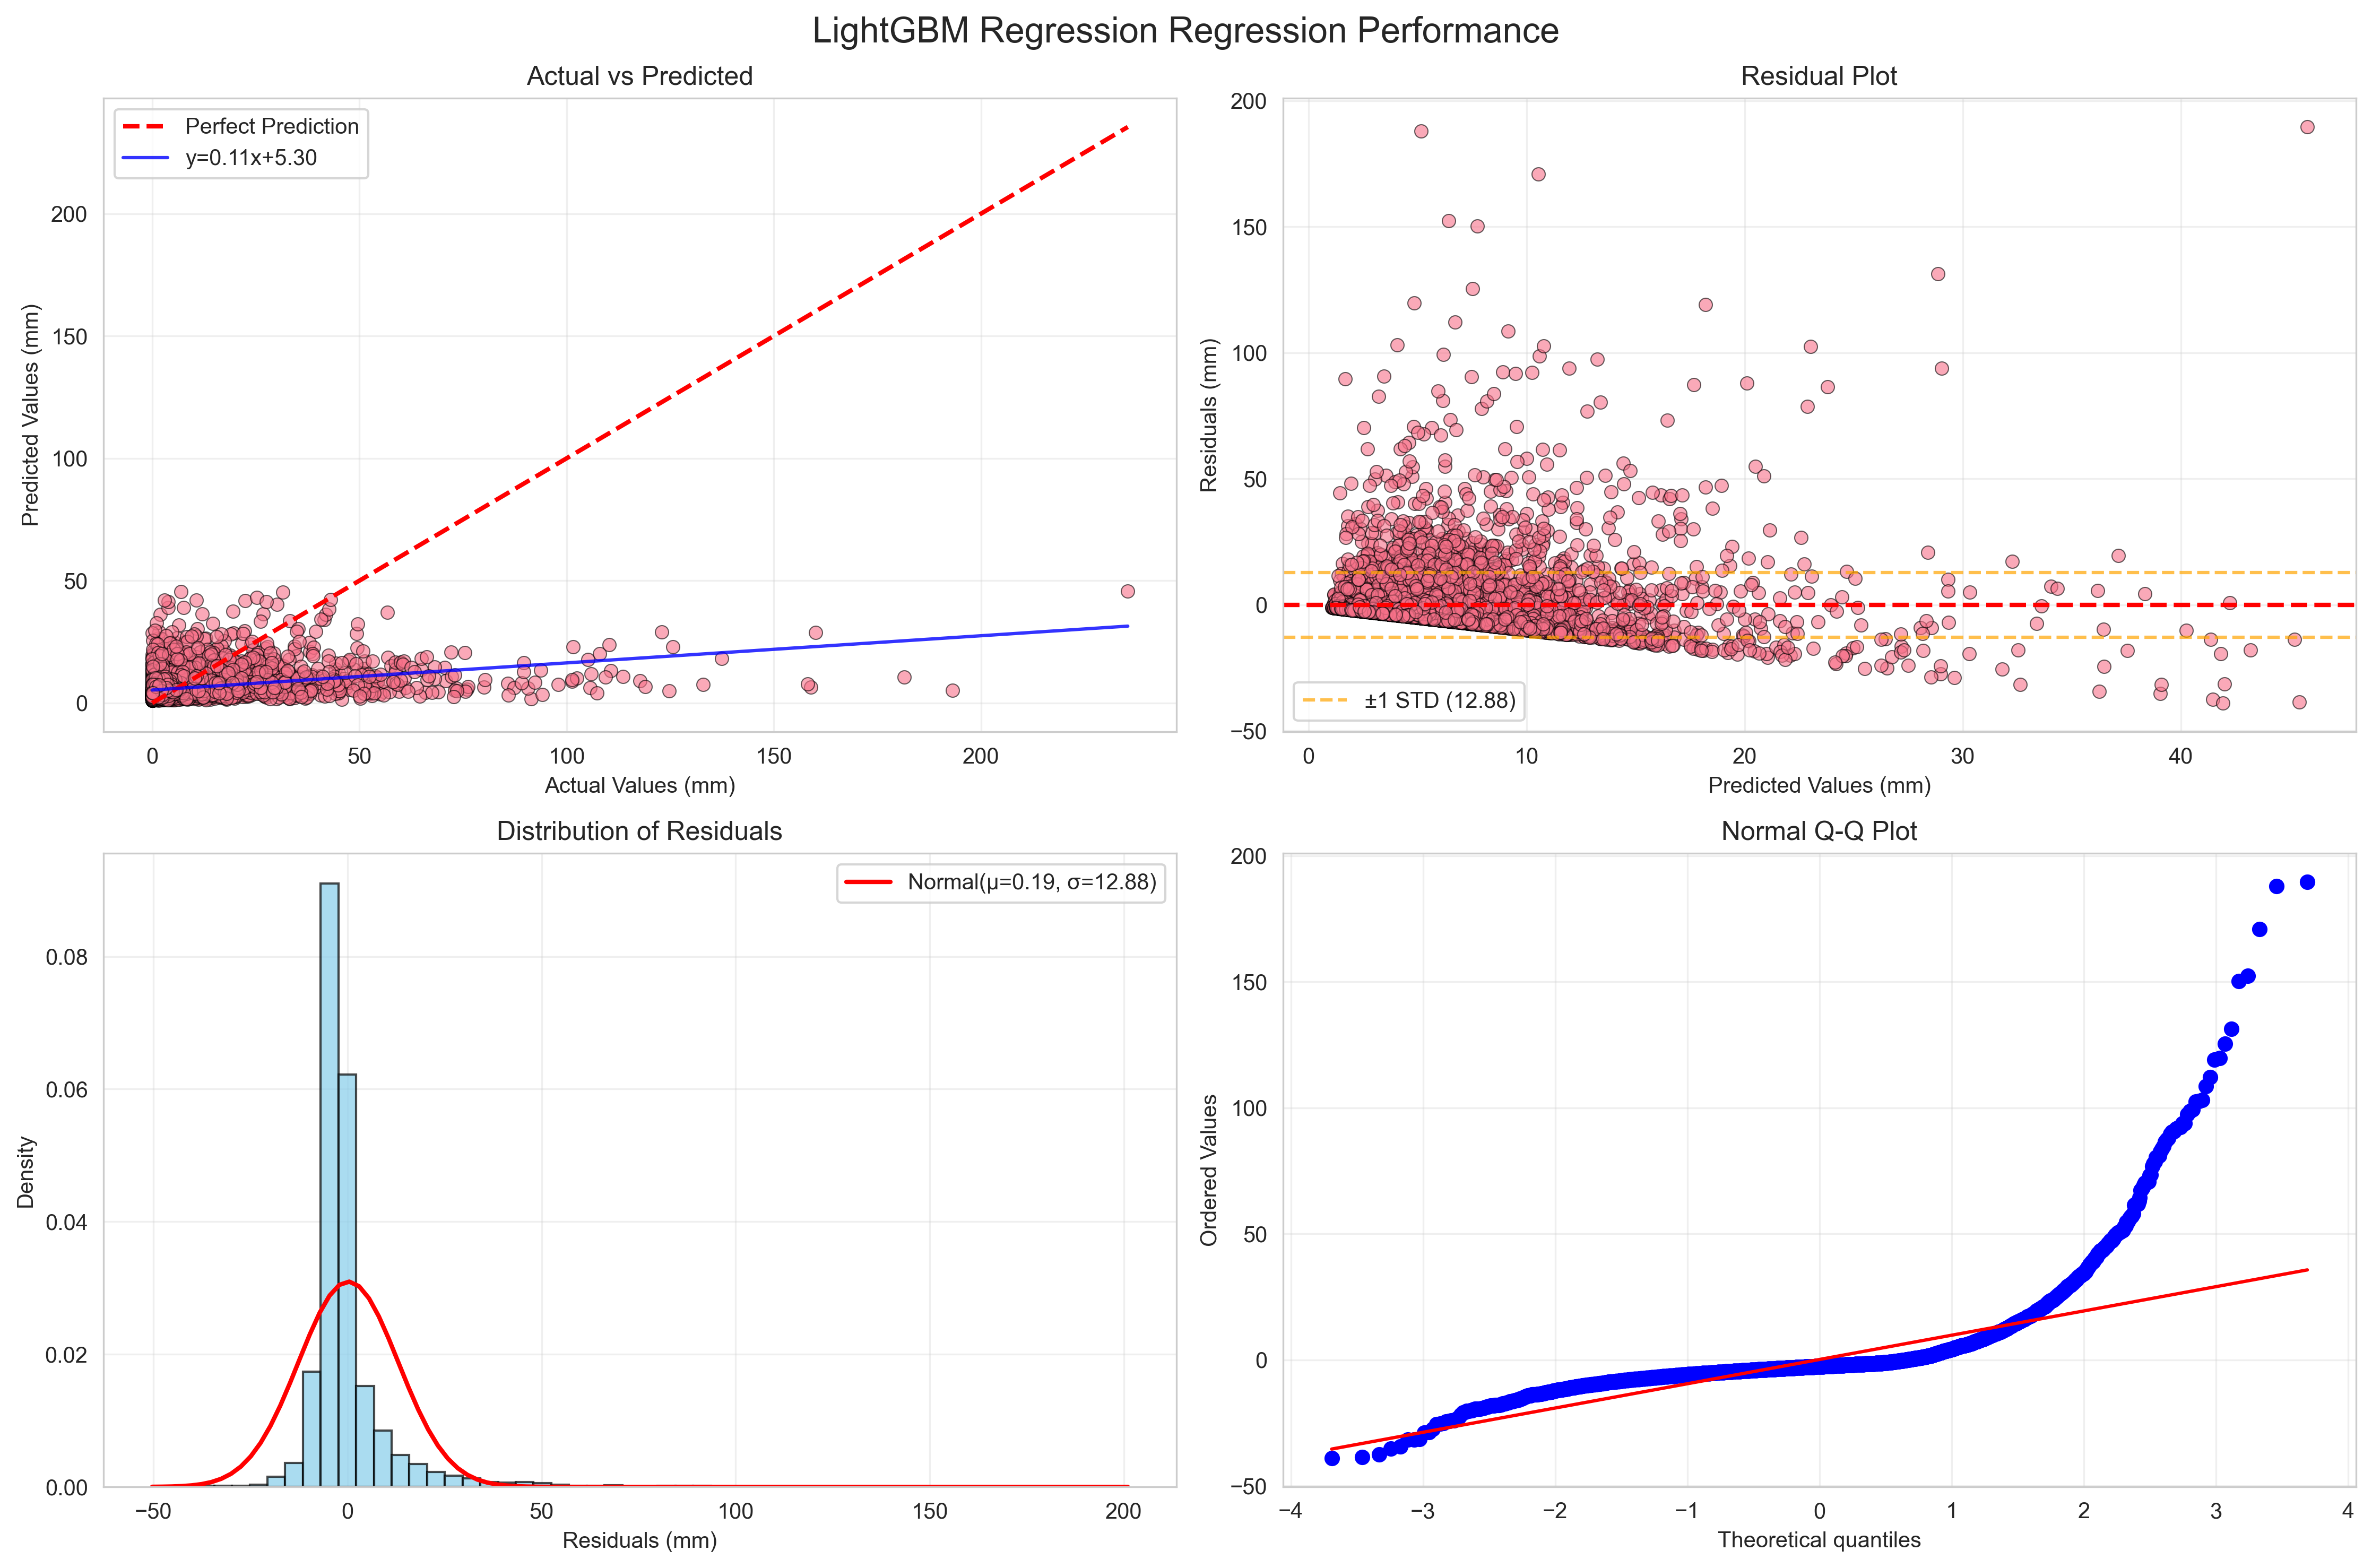

In [62]:
# Visualize regression model performance using weather module
fig = weather.plot_regression_performance(
    y_test, 
    y_test_pred,
    model_name='LightGBM Regression'
)

In [63]:
# <Student to fill this section>
model_performance_explanations = """
LightGBM marginally improves through capturing feature interactions but remains limited by static approach. 
Model still treats days independently without temporal context. Performance ceiling reflects fundamental 
limitation of ignoring time-series nature of weather systems.
"""

In [64]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [65]:
# <Student to fill this section>
business_impacts_explanations = """
Slight improvement insufficient for operational needs due to missing temporal dynamics. Static predictions 
ignore weather system movement and evolution patterns. Practical deployment requires time-series models 
tracking atmospheric changes over consecutive days.
"""

In [66]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## K. Project Outcomes

In [67]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Partially Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [68]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [69]:
# <Student to fill this section>
experiment_results_explanations = """
Tree-based methods cannot overcome fundamental limitation of static feature approach. Weather forecasting 
inherently requires sequential modeling capturing atmospheric evolution. Results emphasize need for LSTM 
or other time-series architectures understanding temporal dependencies.
"""

In [70]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)